In [1]:
import core.utils.configuration

Config = core.utils.configuration.initialize_config()

with Config:
    Config.Model = dict(
        structure=dict(
            encoder = dict(name='timm-efficientnet-b5',weights='noisy-student'),
            decoder = dict(name='UnetDepthSkipV2_multihead',out_channels=[1024,512,256],squeeze=2,head=8),
            heatmap_head = dict(name='CustomV4_interpolate',use_paf=True, layers=5),
            detection_head = None#dict(name='CustomV1')
            ),
        weights=None,
        freeze=dict())
    
    Config.Training.Settings.TrailNumber = 2
    Config.Training.Settings.Epochs = 3
    Config.Training.Settings.AmpScaleTrain = True
    
    Config.Training.Settings.Random.RootSeed = 100
    Config.Training.Settings.Random.cuDNN.Deterministic = True
    Config.Training.Settings.Random.cuDNN.Benchmark = True
    Config.Training.Dataset.CocoPath = 'D:/Datasets/coco2017'
    Config.Training.Dataset.GolferPath = r'D:\Datasets\Golf\IdealsLab2\data'
    Config.Training.Dataset.NumWorkers = 0
    Config.Training.Dataset.PinMemory = False
    Config.Training.Dataset.PrefetchFactor = 2
    
    Config.Training.Dataset.Train.BatchSize = 16
    Config.Training.Dataset.Train.Composition = dict(base_count=100,golfer_schedule=0,coco_human_shcedule=1,coco_dummy_schedule=0)
    
    Config.Training.Dataset.Val.BatchSize = 8
    Config.Training.Dataset.Val.Composition = dict(base_count=50,golfer_schedule=3,coco_human_shcedule=2,coco_dummy_schedule=1)

    Config.Training.HybridLoss = {
        'multi_people_heatmap_param':        dict(shcedule=1,weight=0.01,delta=0.7,gamma=0),
        'leading_role_heatmap_param':       dict(shcedule=1,weight=0.01,delta=0.7,gamma=0),
        'golfclub_heatmap_param':           dict(shcedule=1,weight=0.01,delta=0.7,gamma=0),
        'leading_role_keypoints_param':     dict(shcedule=0,bbox_size=10),
        'leading_role_keypoints_cf_param':  dict(shcedule=0,delta=0.5,gamma=0.5,label_smoothing=0.05),
        'golfclub_keypoints_param':         dict(shcedule=0,bbox_size=10),
        'golfclub_keypoints_cf_param':      dict(shcedule=0,delta=0.8,gamma=0.7,label_smoothing=0.05),
        'leading_role_bbox_param':          dict(shcedule=0),
        'leading_role_bbox_cf_param':       dict(shcedule=0,delta=0.5,gamma=0.5,label_smoothing=0.05)
    }
    
    Config.Training.Optimizer.Name = 'Adam'
    Config.Training.Optimizer.Param = {'lr':0.001}
    Config.Training.LearningRateSchedule.Name = 'LinearWarmupExpReduce'
    Config.Training.LearningRateSchedule.Param = {'warmup_epochs':2}
    
    Config.Record.Frequence = 8
    Config.Record.RootPath = 'test_save_folder'
    Config.Record.SaveModelWeights = True
    Config.Record.VisualizeRatio = 1
    Config.Record.DetectThreshold = 0.5
    Config.Record.Note = ''

In [2]:
import core.utils

dataloaders = core.utils.get_dataloaders(Config)

loading annotations into memory...
Done (t=13.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [3]:
val_imgs = next(iter(dataloaders['val'](0)))['image']

EPOCH: 0:   0%|          | 0/38 [00:00<?, ?it/s]


In [4]:
import matplotlib.pyplot as plt

import torch
from torchvision import transforms


img = val_imgs[:1,...]

torch.Size([1, 3, 288, 512])

In [5]:
hk = torch.tensor([1.,-1.])[None,None,:,None].tile(3,1,1,1)
vk = torch.tensor([-1.,1.])[None,None,None,:].tile(3,1,1,1)

In [14]:
vd_image = torch.max(torch.nn.functional.conv2d(val_imgs,vk,padding='same',groups=3),dim=1)[0]
hd_image = torch.max(torch.nn.functional.conv2d(val_imgs,hk,padding='same',groups=3),dim=1)[0]

mag_image = torch.sqrt(vd_image**2+hd_image**2)
dir_image = torch.arctan((hd_image+1e-30)/(vd_image+1e-30))

In [15]:
centers = torch.arange(0,8,dtype=float)*180/torch.pi
distri = torch.distributions.von_mises.VonMises(loc=centers, concentration=3)
p_distri = torch.ones(8) / 8

raw_hist_image = torch.exp(distri.log_prob(dir_image[...,None]*2))
raw_hist_image = raw_hist_image * p_distri
raw_hist_image = raw_hist_image / raw_hist_image.sum(axis=-1,keepdim=True)

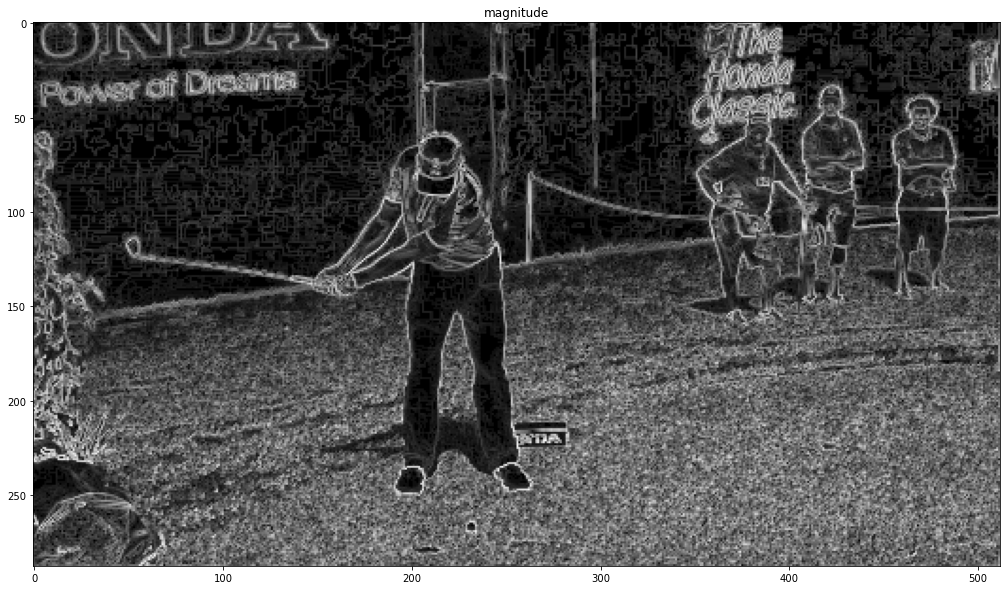

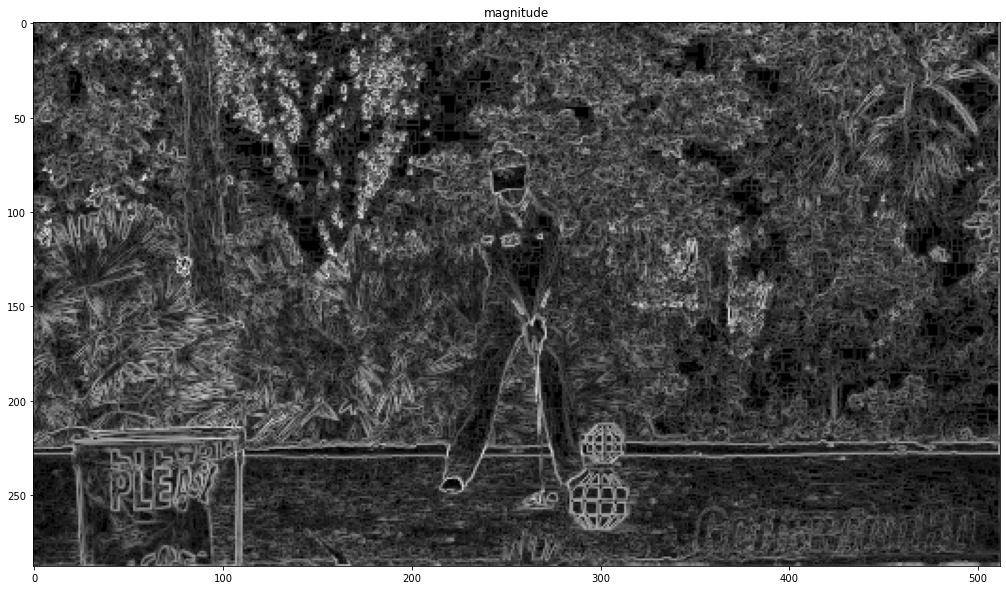

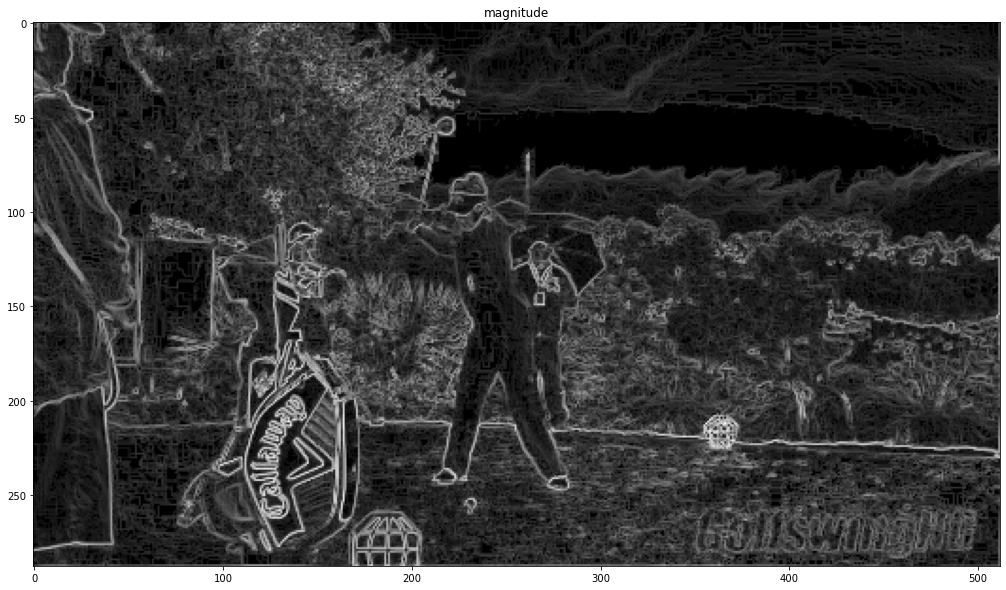

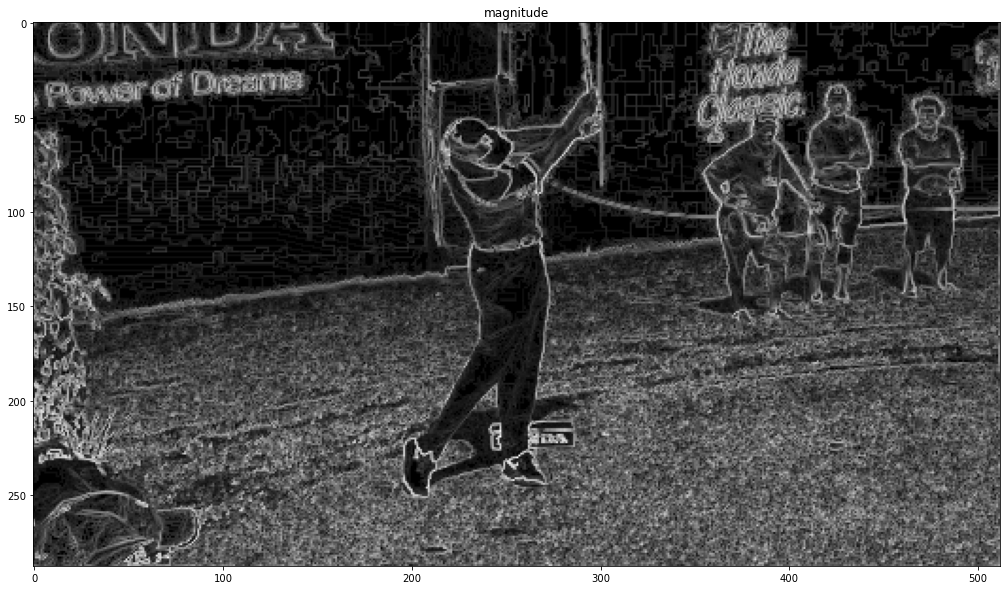

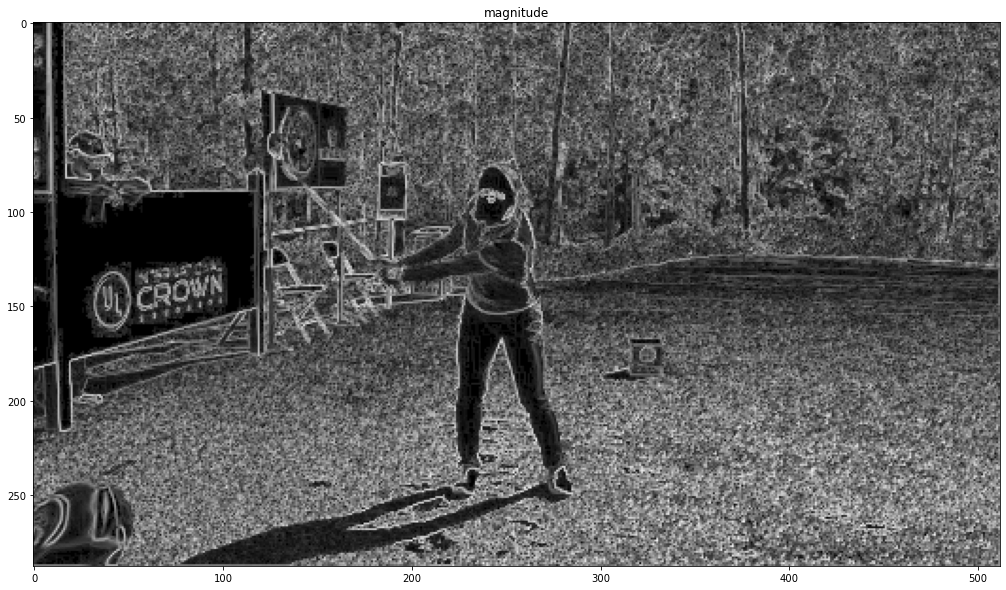

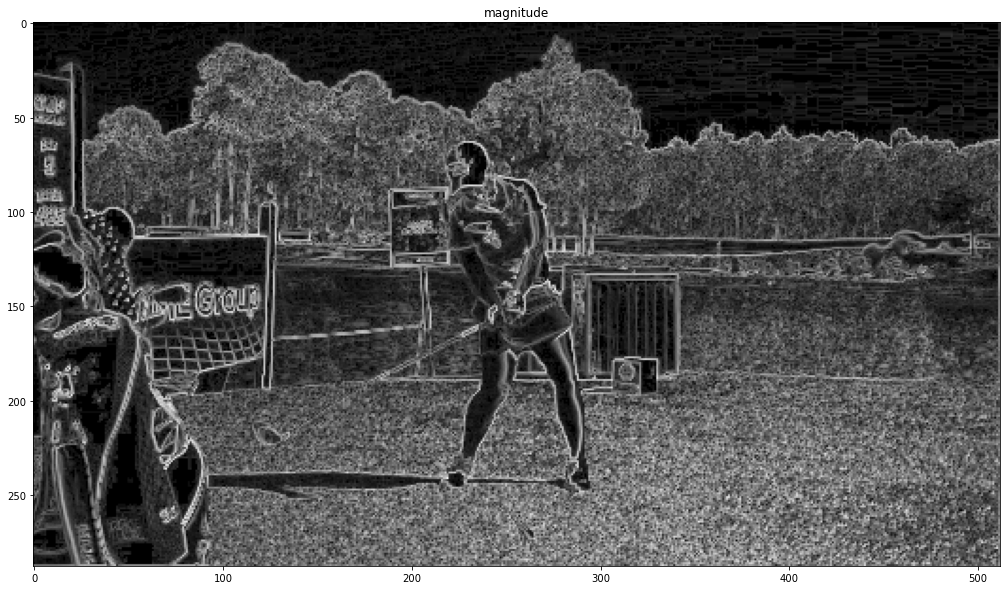

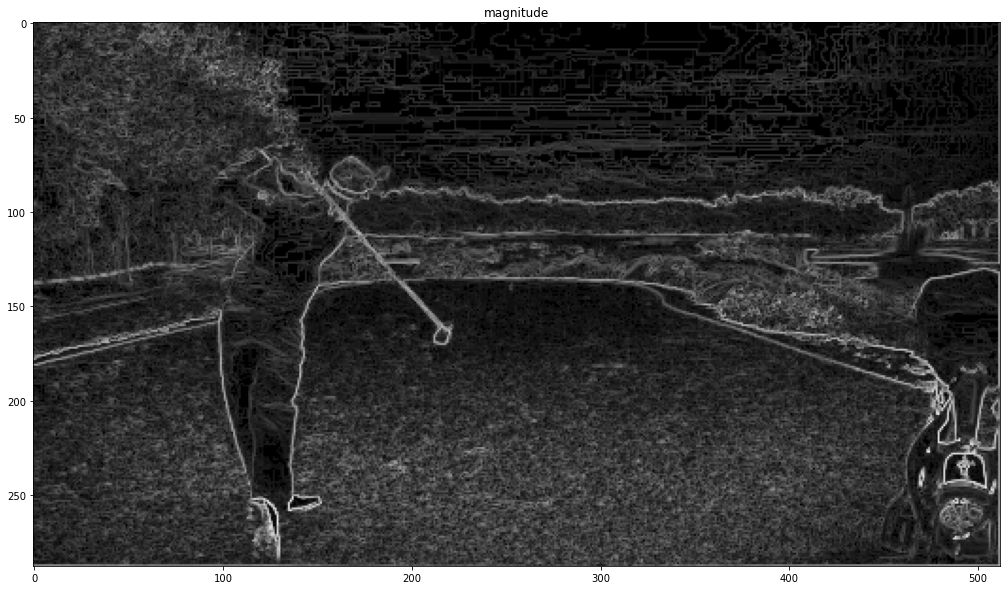

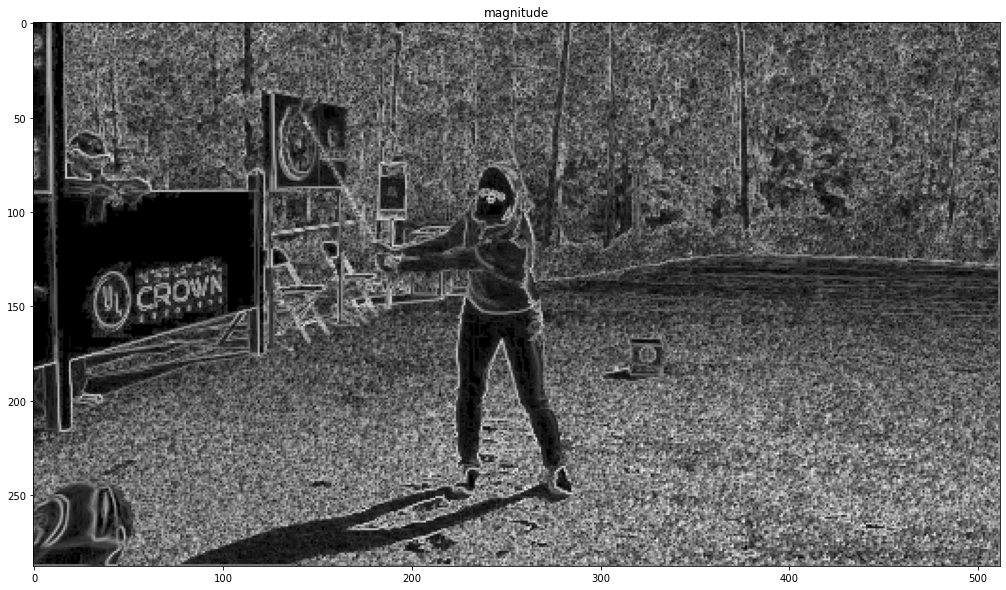

In [16]:
for img in mag_image:
    plt.figure(figsize=(20,10))
    plt.title('magnitude')
    plt.imshow(img**0.5,cmap='gray')
    plt.show()